In [1]:
import numpy as np
import pandas as pd
import pickle as pkl

import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scipy.stats import ttest_ind, ttest_rel

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
common_norm_df = pd.read_csv('/content/drive/MyDrive/aacb_project/datasets/common_normalized.csv', index_col=0)
df_new = pd.read_csv("/content/drive/MyDrive/aacb_project/datasets/control_pcos_celltype_mapping.csv")

normal = ["control", "obese", "pioglitazone", "lean", "valproic"]
pcos = ["PCOS", "PCOS_lean", "PCOS_obese", "PCOS_insulin_res"]
replacement = {}
for i in normal:
    replacement[i] = 0
for i in pcos:
    replacement[i] = 1

position = []
values = list(df_new["sample_id"])
for i,j in enumerate(common_norm_df["sample_id"]):
    position.append(values.index(j))

df_new = df_new.loc[position]
df_new = df_new.reset_index()
df_new = df_new.drop("index", axis=1)

result = pd.merge(common_norm_df, df_new[df_new.columns[:-1]], how='inner', on='sample_id')
gene_feature_ids = result.columns[1:-3]

result["PCOS"] = df_new["PCOS/Control"]
result.drop(["PCOS/Control"], axis=1, inplace=True)
result.replace({"PCOS":replacement}, inplace=True)

gene_feature_ids = result.columns[1:-3]

In [4]:
# Setting up the possible latent dimensions
# A total of 27 latent dimensions are taken under consideration

k_list = []
k_list.extend(list(range(2, 10)))
k_list.extend(list(range(10, 20, 2)))
k_list.extend(list(range(20, 50, 5)))
k_list.extend(list(range(50, 61, 10)))
k_list.append(78)
k_list.extend(list(range(80, 100, 10)))
k_list.extend(list(range(100, 176, 25)))

print("Latent dimensions:")
print(k_list)

model_list = ["pca", "ica", "nmf", "dae", "vae"]
print(model_list)

Latent dimensions:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 60, 78, 80, 90, 100, 125, 150, 175]
['pca', 'ica', 'nmf', 'dae', 'vae']


In [5]:
f1 = open('/content/drive/MyDrive/aacb_project/datasets/z_dict_pcos.p', 'rb')
z_dict_pcos = pkl.load(f1)
f1.close()
f2 = open('/content/drive/MyDrive/aacb_project/datasets/z_dict_control.p', 'rb')
z_dict_control = pkl.load(f2)
f2.close()

In [6]:
def ttest_difference(a_activation, b_activation):
    t_stat, t_p = ttest_ind(a_activation, b_activation, equal_var=False)
    return([t_stat, t_p])

def get_ttest_results(model_list, k_list, group_a, group_b):
    full_results = []
    for model in model_list:
        print("Model:", model)
        time.sleep(1)
        a_recon = group_a[model]
        b_recon = group_b[model]
        for z_dim in tqdm(k_list):
            a_recon_z = np.array(a_recon[z_dim]).transpose()
            b_recon_z = np.array(b_recon[z_dim]).transpose()
            for i in range(len(gene_feature_ids)):
                feature_num = gene_feature_ids[i]
                if i < len(a_recon_z):
                  a_act = a_recon_z[i]
                else:
                  a_act = []
                if i < len(b_recon_z):
                  b_act = b_recon_z[i]
                else:
                  b_act = []
                t_stat, t_p = ttest_difference(a_act, b_act)

                result_df = pd.DataFrame({'t_stat': [t_stat], 't_p': [t_p], 'algorithm': [model], 'feature_num': feature_num, 'z_dim': z_dim}).fillna(1)
                full_results.append(result_df)

    full_results_df = pd.concat(full_results)
    full_results_df = full_results_df.assign(neg_log_p=-np.log10(full_results_df.t_p + 1e-300))
    full_results_df = full_results_df.sort_values(by='neg_log_p', ascending=False)
    full_results_df = full_results_df.reset_index(drop=True)
    return full_results_df

In [7]:
pcos_vs_control_ttest_df = get_ttest_results(model_list, k_list, z_dict_pcos, z_dict_control)

Model: pca


100%|██████████| 28/28 [01:15<00:00,  2.71s/it]


Model: ica


100%|██████████| 28/28 [01:17<00:00,  2.75s/it]


Model: nmf


100%|██████████| 28/28 [01:16<00:00,  2.71s/it]


Model: dae


100%|██████████| 28/28 [01:16<00:00,  2.73s/it]


Model: vae


100%|██████████| 28/28 [01:18<00:00,  2.82s/it]


In [8]:
print(pcos_vs_control_ttest_df.head(20))
print(pcos_vs_control_ttest_df.shape)

      t_stat       t_p algorithm feature_num  z_dim  neg_log_p
0  -5.262154  0.000002       pca      148753     30   5.665022
1  -5.307754  0.000003       pca      148753     25   5.502522
2  -4.529234  0.000021       ica        2350     40   4.676669
3   4.144507  0.000064       pca         389     60   4.190564
4  -5.846541  0.000069       ica        4801      8   4.158072
5   4.445492  0.000100       pca         949     18   3.999575
6   4.017238  0.000106       ica      254359     60   3.973541
7  -4.065977  0.000117       ica       10465     40   3.932611
8   3.851503  0.000191       pca        8085     60   3.718171
9   4.178219  0.000195       pca       23360     18   3.709140
10  4.432373  0.000217       pca       60485     12   3.663171
11  3.951323  0.000254       ica       83715     25   3.594646
12  6.349668  0.000286       pca        3831      5   3.543849
13  4.145593  0.000292       pca        2987     16   3.535346
14  4.748202  0.000318       pca       51150      8   3

In [9]:
pc = pcos_vs_control_ttest_df.iloc[0]
print("PCOS vs Control:", pc['algorithm'], pc['feature_num'], pc['z_dim'], pc['neg_log_p'])

PCOS vs Control: pca 148753 30 5.665021548207784


In [10]:
# pcos vs control
pcos_control_df = [pd.DataFrame(y) for x, y in pcos_vs_control_ttest_df.groupby(['z_dim', 'algorithm'], as_index=False)]
top_features_per_algo_across_k = dict(zip(model_list, [[] for _ in range(len(model_list))]))
for pcdf in pcos_control_df:
    pcdf = pcdf.sort_values(by='neg_log_p', ascending=False)
    top_df = pcdf.iloc[0]
    top_features_per_algo_across_k[top_df['algorithm']].append([top_df['feature_num'], top_df['z_dim'], top_df['neg_log_p']])

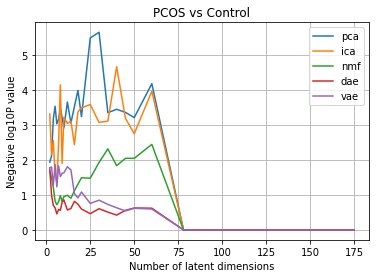

In [15]:
plt.figure()
for model in model_list:
  feat_df = top_features_per_algo_across_k[model]
  dim = [x[1] for x in feat_df]
  nlp = [x[2] for x in feat_df]
  plt.plot(dim, nlp, label=model)
plt.legend()
plt.grid()
plt.xlabel('Number of latent dimensions')
plt.ylabel('Negative log10P value')
plt.title('PCOS vs Control')
plt.savefig('/content/drive/MyDrive/aacb_project/images/PCOS_vs_Control_t_test.png')